In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import pyyawt
import tisean
import math
%matplotlib inline

In [2]:
def f1(t):
    return np.sin(5*t)
def f2(t):
    return np.piecewise(t, [(t>=-10)&(t<0), (t>=0)&(t<=10)], [lambda t: -t**2/2, lambda t: t**2/2])
def f3(t):
    return np.piecewise(t, [(t>=-10)&(t<-2), (t>=-2)&(t<=7), (t>7)&(t<=10)], [5, -3, 8])
def f4(t):
    return np.piecewise(t
                        , [(t>=-10)&(t<=-3.33), (t>-3.33)&(t<=-1.11), (t>-1.11)&(t<=1.11)
                           , (t>1.11)&(t<=3.33), (t>3.33)&(t<=6.66), (t>6.66)&(t<=10)]
                        , [lambda t: np.sin(5*t), lambda t: np.sin(-3.33*t), 2
                          , -3.33**2/2, lambda t: -(t-6.66)**2/2, lambda t: (t-6.66)**2/2])
def f5(t):
    a = np.array([1, -.24, .13, .3, -.2, .3, -.3])
    b = np.array([1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, .9])
    ar = np.r_[1, -a]
    ma = np.r_[b]
    y = smt.arma_generate_sample(ar=ar, ma=ma, nsample=20001, burnin=300, sigma=0.02)
    return y

In [3]:
def f1_plot(t):
    plt.plot(t, np.sin(5*t))
    plt.show()
def f2_plot(t):
    plt.plot(t, f2(t))
    plt.show()
def f3_plot(t):
    f_3 = np.select([(t>=-10)&(t<-2), (t>-2)&(t<7), (t>7)&(t<=10)], [5, -3, 8], np.nan)
    plt.plot(t, f_3)
    plt.show()
def f4_plot(t):
    f1 = lambda t: np.sin(5*t)
    f2 = lambda t: np.sin(-3.33*5)
    f5 = lambda t: -(t-6.66)**2/2
    f6 = lambda t: (t-6.66)**2/2
    f_4 = np.select([(t>=-10)&(t<-3.33)
                     , (t>-3.33)&(t<-1.11)&(np.logical_not(np.isclose(t,-1.11)))
                     , (np.logical_not(np.isclose(t,-1.11)))&(t>-1.11)&(t<1.11)&(np.logical_not(np.isclose(t,1.11)))
                     , (np.logical_not(np.isclose(t,1.11)))&(t>1.11)&(t<3.33), (t>3.33)&(t<6.66), (t>6.66)&(t<=10)]
                    , [f1(t), f2(t), 2, -3.33**2/2, f5(t), f6(t)]
                    , np.nan)
    plt.plot(t, f_4)
    plt.show()
def f5_plot(t):
    plt.plot(t, f5(t))
    plt.show()

In [4]:
temp = np.linspace(-10, 10, 20001)

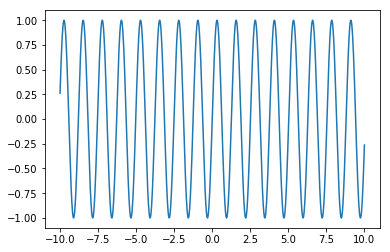

In [5]:
f1_plot(temp)

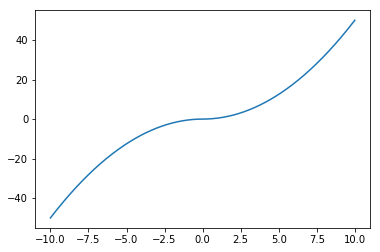

In [6]:
f2_plot(temp)

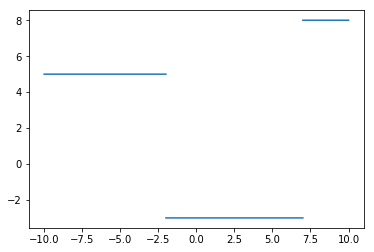

In [7]:
f3_plot(temp)

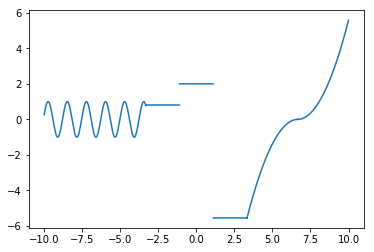

In [8]:
f4_plot(temp)

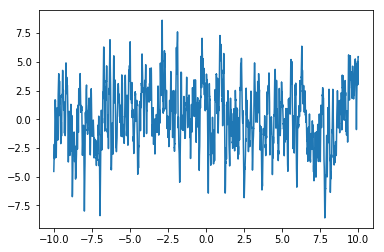

In [9]:
f5_plot(temp)

In [10]:
def moving_average_filter(t):
    w = np.ones(5)
    w = w/w.sum()
    t = np.lib.pad(t, (2,2), 'symmetric') # symmetric padding
    return np.convolve(w, t, 'valid')
def exponential_smoothing_filter(t, a=0.2):
    result = np.copy(t)
    for i in range(len(result)):
        if i!=0:
            result[i] = a*result[i] + (1-a)*result[i-1]
    return result
def linear_fourier_smoothing(t, cutoff=10.0):
    '''
    https://www.scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html
    '''
    t_fft = np.fft.fft(t)
    power = np.abs(t_fft)
    sample_freq = np.fft.fftfreq(t.size, 1e-3)
    high_freq_fft = t_fft.copy()
    high_freq_fft[np.abs(sample_freq) > cutoff] = 0
    return np.real(np.fft.ifft(high_freq_fft))
def wavelet_shrinkage(t, filt='db8', level=5):
    '''
    https://github.com/holgern/pyyawt
    http://matlab.izmiran.ru/help/toolbox/wavelet/wden.html
    '''
    #noisy_coefs = pywt.wavedec(t, filt, mode='per')
    #denoised = noisy_coefs[:]
    #sigma = mad(noisy_coefs[-1])
    #uthresh = sigma*np.sqrt(2*np.log(len(t)))
    #denoised[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in denoised[1:])
    #signal = pywt.waverec(denoised, filt, mode='per')
    #return signal[1:]
    denoised,_,_ = pyyawt.denoising.wden(series, 'sqtwolog', 's', 'mln', level, filt)
    return denoised
def tisean_denoise(t):
    '''
    https://gist.github.com/benmaier/3d7a10a4492c19bd91ce270fa2321519
    https://www.pks.mpg.de/~tisean/TISEAN_2.1/docs/docs_c/nrlazy.html
    '''
    return tisean.nrlazy(input=t, m=8, i=1, r=0.1, d=314)

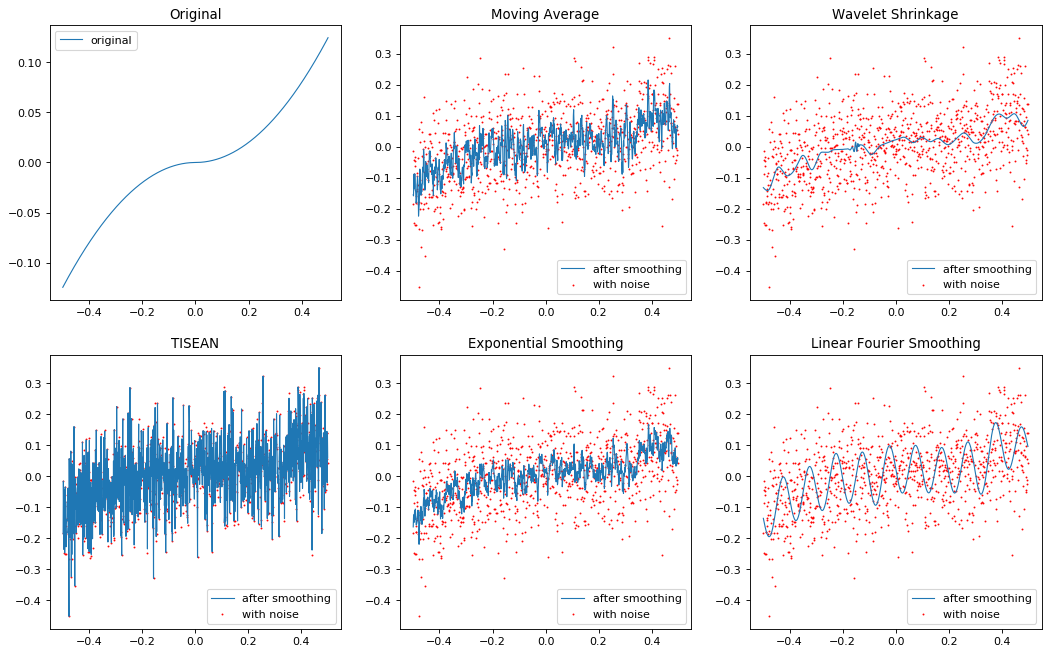

In [11]:
idx = np.where((temp>-0.5) & (temp < 0.5))
#idx = np.where(temp>-20)
f_1 = f2(temp)
series = f_1 + np.random.randn(len(temp))*0.1
ma = moving_average_filter(series)
em = exponential_smoothing_filter(series)
lf = linear_fourier_smoothing(series) # cutoff=500
wl = wavelet_shrinkage(series) # filt='coif2'
ti = tisean_denoise(series) # TISEAN 2.1 and nrlazy

temp_part = temp[idx]
f_1_part = f_1[idx]
series_part = series[idx]
ma_part = ma[idx]
em_part = em[idx]
lf_part = lf[idx]
wl_part = wl[idx]
ti_part = ti[idx]

plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 3, 1)
plt.plot(temp_part, f_1_part, label='original', linewidth=1)
plt.title('Original')
plt.legend()
plt.subplot(2, 3, 2)
plt.scatter(temp_part, series_part, color='r', label='with noise', s=0.5)
plt.plot(temp_part, ma_part, label='after smoothing', linewidth=1)
plt.title('Moving Average')
plt.legend()
plt.subplot(2, 3, 3)
plt.scatter(temp_part, series_part, color='r', label='with noise', s=0.5)
plt.plot(temp_part, wl_part, label='after smoothing', linewidth=1)
plt.title('Wavelet Shrinkage')
plt.legend()
plt.subplot(2, 3, 4)
plt.scatter(temp_part, series_part, color='r', label='with noise', s=0.5)
plt.plot(temp_part, ti_part, label='after smoothing', linewidth=1)
plt.title('TISEAN')
plt.legend()
plt.subplot(2, 3, 5)
plt.scatter(temp_part, series_part, color='r', label='with noise', s=0.5)
plt.plot(temp_part, em_part, label='after smoothing', linewidth=1)
plt.title('Exponential Smoothing')
plt.legend()
plt.subplot(2, 3, 6)
plt.scatter(temp_part, series_part, color='r', label='with noise', s=0.5)
plt.plot(temp_part, lf_part, label='after smoothing', linewidth=1)
plt.title('Linear Fourier Smoothing')
plt.legend()

In [12]:
def l1_norm(f, f_den, dt=1e-3):
    return dt * np.sum(np.abs(f-f_den))
def l2_norm(f, f_den, dt=1e-3):
    return (dt * np.sum(np.square(f-f_den)))**0.5
def l_inf_norm(f, f_den, dt=1e-3):
    return np.amax(np.abs(f-f_den))
def min_euclid_distance(t, y, A, diff_span, loc):
    orig = np.array([t[loc], y])
    start = max(0, loc-diff_span)
    end = min(len(A), loc+diff_span)
    if start == end: end += 1
    min_dis = np.amin([np.linalg.norm(orig-np.array([t[i], A[i]])) for i in range(start,end)])
    return min_dis
def visual_error(t, f, f_den, dt=1e-3):
    size = len(t)
    ve_prev = sum(min_euclid_distance(t
                                      , f[i]
                                      , f_den
                                      , math.ceil(abs(f[i]-f_den[i])/dt), i)**2
                  for i in range(size))
    return (dt * ve_prev)**0.5
def sym_visual_error(t, f, f_den, dt=1e-3):
    ve_1 = visual_error(t, f, f_den)**2
    ve_2 = visual_error(t, f_den, f)**2
    return (ve_1 + ve_2)**0.5

In [13]:
import pandas as pd
def highlight_min(s):
    '''
    highlight the minimum in a series bold.
    '''
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]
def quality_measures(t, f, series, ma, wl, ti, em, lf):
    df = pd.DataFrame(0, index=['Noisy data','MA filter','Wavelet filter'
                                ,'TISEAN','Exp. smoothing','FFT filter']
                      , columns=(r'$L^1$',r'$L^2$',r'$L^{\infty}$',r'$SE_2$'))
    data = [series, ma, wl, ti, em, lf]
    for i in range(len(data)):
        temp_data = data[i]
        data_append = [l1_norm(f, temp_data), l2_norm(f, temp_data)
                       , l_inf_norm(f, temp_data), sym_visual_error(t, f, temp_data)]
        df.iloc[i,:] = data_append
    df = df.round(3)
    #df = df.style.apply(highlight_min)
    return df

In [14]:
df = quality_measures(temp, f_1, series, ma, wl, ti, em, lf)
df

,$L^1$,$L^2$,$L^{\infty}$,$SE_2$
Noisy data,1.581,0.442,0.432,0.175
MA filter,0.703,0.197,0.182,0.083
Wavelet filter,0.286,0.081,0.068,0.042
TISEAN,1.556,0.437,0.432,0.170
Exp. smoothing,0.652,0.182,0.173,0.068
FFT filter,5.165,7.109,49.016,2.051


In [15]:
df.applymap(lambda x: str(x) + '±' + '0.1')

,$L^1$,$L^2$,$L^{\infty}$,$SE_2$
Noisy data,1.581±0.1,0.442±0.1,0.432±0.1,0.175±0.1
MA filter,0.703±0.1,0.197±0.1,0.182±0.1,0.083±0.1
Wavelet filter,0.286±0.1,0.081±0.1,0.068±0.1,0.042±0.1
TISEAN,1.556±0.1,0.437±0.1,0.432±0.1,0.17±0.1
Exp. smoothing,0.652±0.1,0.182±0.1,0.173±0.1,0.068±0.1
FFT filter,5.165±0.1,7.109±0.1,49.016±0.1,2.051±0.1
